In [ ]:
#Importing Libraries

import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Loading data 

# Dataframe
path_df = "/content/drive/My Drive/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/content/drive/My Drive/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/content/drive/My Drive/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/content/drive/My Drive/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/content/drive/My Drive/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [ ]:
#Checking the dimensions of feature vectors

print(features_train.shape)
print(features_test.shape)

(1891, 300)
(334, 300)


1) Cross-Validation for Hyperparameter tuning

In [ ]:
#Checking which hyper parameters the model has

svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


Random Search Cross Validation

In [ ]:
#Defining grid for Randomized Search Cross Validation

C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [ ]:
#Random Search

# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 14.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=8,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_s

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.9217358857612424


Grid Search Cross validation

In [ ]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  8.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=8, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated'...one,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability':

In [ ]:
#Finding best hyperparameters
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9498666666666665


In [ ]:
#Saving the model and displaying it

best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

Model fit and performance

In [ ]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
svc_pred = best_svc.predict(features_test)

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9592808038075092


In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.9401197604790419


In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.88      0.98      0.92        81
           1       0.96      0.94      0.95        49
           2       0.97      0.89      0.93        72
           3       0.99      0.99      0.99        72
           4       0.93      0.90      0.92        60

    accuracy                           0.94       334
   macro avg       0.94      0.94      0.94       334
weighted avg       0.94      0.94      0.94       334



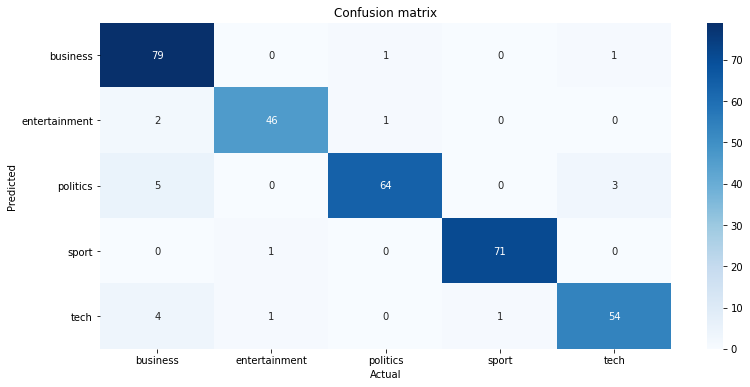

In [ ]:
#Confusion Matrix

aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Base mode vs. Tuned Mode

In [ ]:
#base model
base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9550898203592815

In [ ]:
#tuned model
best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))

0.9401197604790419

In [ ]:
#storing modedl details

d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])


In [ ]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.959281,0.94012


In [ ]:
#Saving model

with open('/content/drive/My Drive/Pickles/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('/content/drive/My Drive/Pickles/df_models_svc.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)